# 3. Word2Vec + 隨機森林

# 對比四種方法
| **方法**                  | **特徵工程**                | **模型**                    | **準確率預估** | **優勢**                                     | **劣勢**                                      | **GPU 支援**            |
|--------------------------|----------------------------|-----------------------------|----------------|---------------------------------------------|----------------------------------------------|-------------------------|
| **TF-IDF + 隨機森林**      | 稀疏特徵表示，詞頻與逆文檔頻率權重 | 隨機森林                    | 75%-82%       | 模型穩定性強，對噪聲和高維數據不敏感          | 無法處理非線性模式，對語義信息利用不足           | 不支持                  |
| **TF-IDF + Boosting**      | 稀疏特徵表示，詞頻與逆文檔頻率權重 | XGBoost 或 LightGBM         | 78%-85%       | 擅長處理稀疏特徵，對錯分樣本有良好適應能力      | 訓練成本略高，需調參以達到最佳效果              | 支持（顯著加速，適合大數據集）|
| **Word2Vec + 隨機森林**     | 詞嵌入，計算句向量平均值       | 隨機森林                    | 72%-80%       | 能結合詞嵌入語義特徵，提升語義捕捉能力          | 詞嵌入需預處理，隨機森林對非線性語義的處理有限     | 不支持                  |
| **Word2Vec + CNN**         | 詞嵌入，保留語序            | 卷積神經網絡                | 75%-85%       | 捕捉局部語義特徵，對短文本效果佳               | 訓練需較多資源，對長文本效果有限               | 支持（顯著加速）         |
| **BERT 嵌入 + Transformer**| 上下文語義嵌入，保留全局語義 | 預訓練 BERT 模型             | 85%-90%       | 能捕捉上下文語義，分類準確率最高               | 訓練和推理成本高，需要大量數據和資源支持         | 支持（必要，否則速度較慢） |

In [1]:
#kaggle 前置作業
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json
/kaggle/input/dm-2024-isa-5810-lab-2-homework/sampleSubmission.csv
/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv
/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv


In [2]:
# 引入必要的庫
import json
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 確保 NLTK 資源可用
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 這部分請小心執行，這是 "未做過"  雜訊處理的程式碼

In [ ]:

# ======== 資料讀取與整理 ========
# 1. 讀取 JSON 格式的推文數據
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
f.close()

# 這部分請小心執行，這是 "做過" 雜訊處理的程式碼

In [3]:
import json
import re
import emoji
import pandas as pd

# 定義表情符號到關鍵字的映射字典
emoji_dict = {
    '😂': '[joy]',
    '❤️': '[love]',
    '😍': '[adoration]',
    '😭': '[cry]',
    '❤': '[care]',
    '😊': '[happy]',
    '🙏': '[pray]',
    '😘': '[kiss]',
    '💕': '[love_each_other]',
    '🔥': '[fire]',
    '😩': '[weary]',
    '🤔': '[think]',
    '💯': '[perfect]',
    '💙': '[loyalty]',
    '🙄': '[annoyed]',
    '😁': '[happy]',
    '🙌': '[celebrate]',
    '🙏🏾': '[pray]',
    '👍': '[approve]',
    '🙏🏽': '[pray]'
}

# 定義清理推文文本的函數
def clean_tweet(text, emoji_dict):
    # 將定義的表情符號替換為對應的關鍵詞
    for emj, keyword in emoji_dict.items():
        text = text.replace(emj, keyword)
    # 移除其餘的表情符號
    text = emoji.replace_emoji(text, replace='')
    # 移除 <LH> 標籤
    text = re.sub(r'<LH>', '', text)
    # 移除多餘的空白字元
    text = text.strip()
    return text

# 讀取推文資料
data1 = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data1.append(json.loads(line))

# 處理每條推文並儲存結果
processed_tweets = []
for entry in data1:
    # 檢查 '_source' 和 'tweet' 是否存在於記錄中
    if '_source' in entry and 'tweet' in entry['_source']:
        tweet = entry['_source']['tweet']
        # 檢查 'text' 是否存在於 'tweet' 中
        if 'text' in tweet:
            tweet_text = tweet['text']
            cleaned_text = clean_tweet(tweet_text, emoji_dict)
            # 創建處理後的推文記錄，保留 '_source' 和 'tweet'
            processed_tweet = {
                '_source': {
                    'tweet': tweet.copy()
                }
            }
            # 更新清理後的文本
            processed_tweet['_source']['tweet']['text'] = cleaned_text
            processed_tweets.append(processed_tweet)
        else:
            print("記錄中缺少 'text' 鍵")
    else:
        print("記錄中缺少 '_source' 或 'tweet' 鍵")

# 將處理後的推文資料存儲為 JSON 檔案
with open('/kaggle/working/tweets_DM_filtered_1.json', 'w') as outfile:
    json.dump(processed_tweets, outfile, ensure_ascii=False, indent=4)



# 將處理後的資料轉換為 DataFrame
df_processed = pd.DataFrame(processed_tweets)

# 定義輸出目錄和檔案名稱
output_dir = '/kaggle/working/'
output_file = 'tweets_DM_filtered_1.json'

# 檢查並創建目錄（如果不存在）
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 將處理後的 DataFrame 儲存為 JSON 檔案
output_path = os.path.join(output_dir, output_file)
df_processed.to_json(output_path, orient='records', lines=True, force_ascii=False)

# 把 /kaggle/working/tweets_DM_filtered_1.json 載入成為 data , 可樣就可以跟原本程式合併

data = []
with open('/kaggle/working/tweets_DM_filtered_1.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
f.close()

In [ ]:
print(data)

# 以下就都跟之前一樣了

In [4]:

# 2. 讀取其他 CSV 文件
emotion = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv')
data_identification = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv')

# ======== 數據處理 ========
# 1. 從 JSON 數據提取 tweet_id, hashtags, 和文本內容
df = pd.DataFrame(data)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})

# 2. 合併資料集標籤 (train/test)
df = df.merge(data_identification, on='tweet_id', how='left')

# 3. 將資料分為訓練集和測試集
train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

# 4. 合併情緒標籤到訓練資料中
train_data = train_data.merge(emotion, on='tweet_id', how='left')

# 5. 移除訓練集中重複的文本
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)

# ======== 訓練數據準備 ========
# 1. 抽取部分訓練數據（30% 抽樣）
train_data_sample = train_data.sample(frac=0.3, random_state=42)

# 2. 提取目標變數 (情緒) 和特徵變數 (文本)
y_train_data = train_data_sample['emotion']
X_train_data = train_data_sample['text']

# 3. 訓練集與測試集劃分 (分層抽樣確保類別分佈一致)
X_train, X_test, y_train, y_test = train_test_split(
    X_train_data, y_train_data, test_size=0.2, random_state=42, stratify=y_train_data
)

# ======== 文本處理與 Word2Vec 訓練 ========
# 1. 將文本分詞
def preprocess_text(text_series):
    return text_series.apply(word_tokenize)

X_train_tokens = preprocess_text(X_train)
X_test_tokens = preprocess_text(X_test)

# 2. 訓練 Word2Vec 模型
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# 3. 將每個文本轉換為向量（平均詞向量）
def text_to_avg_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_train_vectors = X_train_tokens.apply(lambda x: text_to_avg_vector(x, word2vec_model)).tolist()
X_test_vectors = X_test_tokens.apply(lambda x: text_to_avg_vector(x, word2vec_model)).tolist()

# ======== 標籤編碼 ========
# 1. 將情緒類別轉換為數值型
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# ======== 模型訓練 ========
# 1. 訓練隨機森林分類器
clf = RandomForestClassifier()
clf.fit(X_train_vectors, y_train_encoded)

# ======== 模型評估 ========
# 1. 預測測試集
y_pred = clf.predict(X_test_vectors)

# 2. 計算準確率
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# ======== 測試數據預測 ========
# 1. 準備測試數據的文本特徵
X_test_data = preprocess_text(test_data['text'])
X_test_data_vectors = X_test_data.apply(lambda x: text_to_avg_vector(x, word2vec_model)).tolist()

# 2. 預測測試數據情緒
y_test_pred = clf.predict(X_test_data_vectors)

# ======== 結果輸出 ========
# 1. 將數值標籤轉換回文字標籤
y_pred_labels = le.inverse_transform(y_test_pred)

# 2. 保存提交檔案
submission = pd.DataFrame({
    'tweet_id': test_data['tweet_id'],
    'emotion': y_pred_labels
})

# 先不產生 submission
# submission.to_csv('/kaggle/working/submission.csv', index=False)


Accuracy: 0.4566
              precision    recall  f1-score   support

       anger       0.97      0.08      0.15      2375
anticipation       0.58      0.37      0.46     14845
     disgust       0.35      0.16      0.22      8390
        fear       0.60      0.08      0.14      3794
         joy       0.44      0.88      0.59     30481
     sadness       0.41      0.35      0.37     11533
    surprise       0.87      0.03      0.06      2737
       trust       0.63      0.10      0.17     12216

    accuracy                           0.46     86371
   macro avg       0.61      0.26      0.27     86371
weighted avg       0.51      0.46      0.39     86371



In [ ]:
submission.head()

# 3. Word2Vec + 隨機森林
# 分析部分 : 混淆矩陣 , Classification Report

## 準確率紀錄 :



### 資料沒過濾
- Accuracy: 0.4586
- Accuracy: 0.4580

### 資料過濾後
- Accuracy: 0.4566

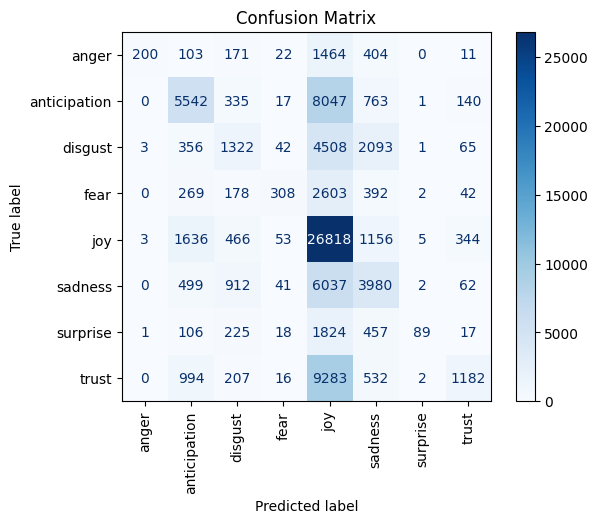


 ---- 

Confusion Matrix:
[[  200   103   171    22  1464   404     0    11]
 [    0  5542   335    17  8047   763     1   140]
 [    3   356  1322    42  4508  2093     1    65]
 [    0   269   178   308  2603   392     2    42]
 [    3  1636   466    53 26818  1156     5   344]
 [    0   499   912    41  6037  3980     2    62]
 [    1   106   225    18  1824   457    89    17]
 [    0   994   207    16  9283   532     2  1182]]

 ---- 


Classification Report:
              precision    recall  f1-score   support

       anger       0.97      0.08      0.15      2375
anticipation       0.58      0.37      0.46     14845
     disgust       0.35      0.16      0.22      8390
        fear       0.60      0.08      0.14      3794
         joy       0.44      0.88      0.59     30481
     sadness       0.41      0.35      0.37     11533
    surprise       0.87      0.03      0.06      2737
       trust       0.63      0.10      0.17     12216

    accuracy                           0.46

In [5]:
# ======== 模型分析與評估 ========

# 1. 畫出混淆矩陣
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 計算混淆矩陣
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# 繪製混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()
print("\n", "----", "\n")


# 2. 列出混淆矩陣
print("Confusion Matrix:")
print(conf_matrix)
print("\n", "----", "\n")


# 3. 做出分類報告
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))
print("\n", "----", "\n")

# 4. 印出 Accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\n", "----", "\n")
